# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [2]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [6]:
# Only for kaggle
!pip install torch_geometric -q

In [4]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
!pip install distinctipy -q

In [7]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
# url = "D:\Grad\Planify_Dataset\Graph\graphs\Graphs_real.pkl"

# for kaggle
url = "/kaggle/input/planify-graphs-all-forms/graphs/Graphs_real.pkl"

<a id='func'></a>
### Functions used

In [8]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [9]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def collate_fn(graphs_list):
    batch = Batch.from_data_list([Data.from_(g) for g in graphs_list])
    return batch

<a id='wrangling'></a>
## Data wrangling


Graph with 8 nodes and 13 edges


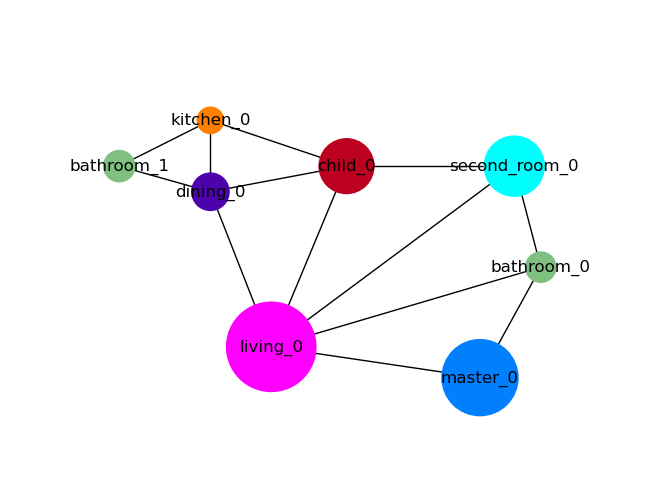

In [11]:
with open(url, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)
draw_graph(G)

In [12]:
# Converting networkx graphs to pytorchGeo graphs
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|██████████| 80787/80787 [00:57<00:00, 1393.40it/s]


Data(edge_index=[2, 18], roomType_name=[7], rec_w=[7], rec_h=[7], roomSize=[7], x=[7, 3], edge_attr=[18, 1])

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [13]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6

    
print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  7.0000, 132.6687, 167.8575],
        [  7.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  9.0000,  77.0000, 210.5000]])


100%|██████████| 80787/80787 [00:04<00:00, 18497.73it/s]

After: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  1.0000, 132.6687, 167.8575],
        [  1.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  4.0000,  77.0000, 210.5000]])


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [14]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    x = G.x # The feature matrix
    for i in [1, 2]:
        mean = torch.mean(x[:, i])
        std  = torch.std(x[:, i])
        
        normalized_column = (x[:, i] - mean) / std
        G.x[:, i] = normalized_column
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:13<00:00, 5992.51it/s]


> If we need to creat graphs with padding by the maximum number of nodes.

In [15]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [16]:
class Planify_Dataset(Dataset):
    def __init__(self, data):
        self.Graphs = data
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(device)
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes).to(device)
        
        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.rec_w = G.rec_w[permutation]
        G.rec_h = G.rec_h[permutation]
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        
        return G

In [17]:
edge = int(len(Graphs_pyTorch) * 0.9)
batch_size = 64

train_dataset = Planify_Dataset(Graphs_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Planify_Dataset(Graphs_pyTorch[edge:])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [18]:
# Saving model function
import os
checkpoint_dir = "./checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'Best_model.pth')
    # Saving model each 15 epochs
#     if epoch % 15 == 0:
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)

<a id='archi'></a>
### Architecture

In [19]:
class GATNet(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(num_node_features, 32, heads=8, dropout=0.5)
        
        input_of_conv2 = 32*8 + 9  # output of conv1 + featurs of the real x = 9 => 265
        self.conv2 = GATConv(input_of_conv2, 64, heads=8, dropout=0.5)
        
        input_of_conv3 = 64*8 + 265 # output of conv2 + input of conv2 => 777
        self.conv3 = GATConv(input_of_conv3, 64, heads=8, dropout=0.5)
        
        input_of_lin1 = 64*8 + 777 # => 1289
        self.lin1 = torch.nn.Linear(input_of_lin1, 32)
        self.lin2 = torch.nn.Linear(32, 2)
                
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        if batch == None:
            batch = torch.zeros(data.x.shape[0], dtype=torch.long)
        
        x_res = x # saving a copy of x for residual connection
        
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        # x = F.dropout(x, p=0.25)
        
        x_res = torch.cat([x_res, x], dim=1) 
        
        x = F.relu(self.conv2(x_res, edge_index, edge_attr))
        # x = F.dropout(x, p=0.25)
        
        x_res = torch.cat([x_res, x], dim=1) 
        
        x = F.relu(self.conv3(x_res, edge_index, edge_attr))
        # x = F.dropout(x, p=0.25)
        
        x_res = torch.cat([x_res, x], dim=1) 
        
        x = F.relu(self.lin1(x_res))
        x = self.dropout(x)
        
        x = self.lin2(x)
        
        return x

num_features = Graphs_pyTorch[9].x.shape[1]
model = GATNet(num_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (conv1): GATConv(9, 32, heads=8)
  (conv2): GATConv(265, 64, heads=8)
  (conv3): GATConv(777, 64, heads=8)
  (lin1): Linear(in_features=1289, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [20]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), desc='Planifying', total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        
        logits    = model(data)
        targets   = torch.cat((data.rec_w.unsqueeze(1), data.rec_h.unsqueeze(1)), dim=1)
        
        loss = criterion(logits, targets)
        
        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
    return running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            out = model(data)
            targets = torch.cat((data.rec_w.unsqueeze(1), data.rec_h.unsqueeze(1)), dim=1)
            loss = criterion(out, targets)
            running_loss += loss.item()
            
    return running_loss / len(val_loader)

<a id='train'></a>
### Training


In [21]:
from copy import deepcopy

# Hyperparameters
learning_rate = 0.001
num_epochs = 30
patience = 8 # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')
best_model = None
counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.972)

train_losses = []
val_losses = []

In [22]:
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
    else:
        print('Model not saved!')
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in [3, 5, 7] :
            scheduler.step()
            print('Learning rate decreased!')

Planifying: 100%|██████████| 1137/1137 [00:49<00:00, 23.03it/s]


Validating ...
Epoch [1/30], Train Loss: 656.4333, Validation Loss: 291.6830


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 24.17it/s]


Validating ...
Epoch [2/30], Train Loss: 402.4411, Validation Loss: 304.8691
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 24.11it/s]


Validating ...
Epoch [3/30], Train Loss: 383.8500, Validation Loss: 269.6029


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.41it/s]


Validating ...
Epoch [4/30], Train Loss: 373.6128, Validation Loss: 286.2910
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.28it/s]


Validating ...
Epoch [5/30], Train Loss: 363.4992, Validation Loss: 278.0228
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.53it/s]


Validating ...
Epoch [6/30], Train Loss: 354.6646, Validation Loss: 243.4948


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.99it/s]


Validating ...
Epoch [7/30], Train Loss: 344.3468, Validation Loss: 237.1355


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.26it/s]


Validating ...
Epoch [8/30], Train Loss: 336.9226, Validation Loss: 235.8882


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.54it/s]


Validating ...
Epoch [9/30], Train Loss: 328.9986, Validation Loss: 242.5349
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 24.19it/s]


Validating ...
Epoch [10/30], Train Loss: 322.2971, Validation Loss: 228.1985


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.89it/s]


Validating ...
Epoch [11/30], Train Loss: 316.6145, Validation Loss: 210.8945


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.97it/s]


Validating ...
Epoch [12/30], Train Loss: 309.8672, Validation Loss: 220.4687
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.37it/s]


Validating ...
Epoch [13/30], Train Loss: 304.3609, Validation Loss: 220.5776
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.40it/s]


Validating ...
Epoch [14/30], Train Loss: 299.3288, Validation Loss: 209.3552


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.49it/s]


Validating ...
Epoch [15/30], Train Loss: 295.4149, Validation Loss: 220.9707
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.31it/s]


Validating ...
Epoch [16/30], Train Loss: 291.2371, Validation Loss: 207.8533


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.56it/s]


Validating ...
Epoch [17/30], Train Loss: 285.5364, Validation Loss: 214.3373
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 24.05it/s]


Validating ...
Epoch [18/30], Train Loss: 281.4605, Validation Loss: 203.3804


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 24.19it/s]


Validating ...
Epoch [19/30], Train Loss: 277.6378, Validation Loss: 199.4389


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.43it/s]


Validating ...
Epoch [20/30], Train Loss: 272.2198, Validation Loss: 194.5025


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.31it/s]


Validating ...
Epoch [21/30], Train Loss: 269.8385, Validation Loss: 196.0468
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.38it/s]


Validating ...
Epoch [22/30], Train Loss: 264.2892, Validation Loss: 195.9774
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.54it/s]


Validating ...
Epoch [23/30], Train Loss: 261.6787, Validation Loss: 192.3770


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.78it/s]


Validating ...
Epoch [24/30], Train Loss: 258.3365, Validation Loss: 198.2565
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.48it/s]


Validating ...
Epoch [25/30], Train Loss: 252.5292, Validation Loss: 199.9043
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.43it/s]


Validating ...
Epoch [26/30], Train Loss: 249.0283, Validation Loss: 193.3400
Model not saved!
Learning rate decreased!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.35it/s]


Validating ...
Epoch [27/30], Train Loss: 246.5290, Validation Loss: 192.7941
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.36it/s]


Validating ...
Epoch [28/30], Train Loss: 243.7064, Validation Loss: 192.1517


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.28it/s]


Validating ...
Epoch [29/30], Train Loss: 240.6083, Validation Loss: 191.1068


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.80it/s]


Validating ...
Epoch [30/30], Train Loss: 237.6291, Validation Loss: 192.5182
Model not saved!


In [25]:
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
    else:
        print('Model not saved!')
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in [3, 5, 7] :
            scheduler.step()
            print('Learning rate decreased!')

Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.88it/s]


Validating ...
Epoch [1/30], Train Loss: 235.6004, Validation Loss: 194.5172
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.52it/s]


Validating ...
Epoch [2/30], Train Loss: 233.4154, Validation Loss: 188.9209


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.28it/s]


Validating ...
Epoch [3/30], Train Loss: 231.7246, Validation Loss: 190.3515
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.25it/s]


Validating ...
Epoch [4/30], Train Loss: 229.6601, Validation Loss: 186.5742


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.58it/s]


Validating ...
Epoch [5/30], Train Loss: 227.5403, Validation Loss: 188.4528
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.75it/s]


Validating ...
Epoch [6/30], Train Loss: 226.1279, Validation Loss: 190.7180
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.49it/s]


Validating ...
Epoch [7/30], Train Loss: 225.6286, Validation Loss: 193.2023
Model not saved!
Learning rate decreased!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.48it/s]


Validating ...
Epoch [8/30], Train Loss: 225.2571, Validation Loss: 190.9970
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.31it/s]


Validating ...
Epoch [9/30], Train Loss: 224.7285, Validation Loss: 191.0997
Model not saved!
Learning rate decreased!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.59it/s]


Validating ...
Epoch [10/30], Train Loss: 224.5852, Validation Loss: 197.2795
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.21it/s]


Validating ...
Epoch [11/30], Train Loss: 223.5111, Validation Loss: 196.3182
Model not saved!
Learning rate decreased!


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.82it/s]


Validating ...
Epoch [12/30], Train Loss: 223.2319, Validation Loss: 190.8270
Model not saved!
Validation loss did not improve for 8 epochs. Stopping early.


In [28]:
counter = 0
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
    else:
        print('Model not saved!')
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in [3, 5, 7] :
            scheduler.step()
            print('Learning rate decreased!')

Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.29it/s]


Validating ...
Epoch [1/30], Train Loss: 221.2036, Validation Loss: 191.4901
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.27it/s]


Validating ...
Epoch [2/30], Train Loss: 221.0428, Validation Loss: 190.6337
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.43it/s]


Validating ...
Epoch [3/30], Train Loss: 220.3223, Validation Loss: 193.2861
Model not saved!
Learning rate decreased!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.30it/s]


Validating ...
Epoch [4/30], Train Loss: 220.3941, Validation Loss: 191.1023
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:47<00:00, 23.95it/s]


Validating ...
Epoch [5/30], Train Loss: 219.4071, Validation Loss: 191.5528
Model not saved!
Learning rate decreased!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.50it/s]


Validating ...
Epoch [6/30], Train Loss: 219.2978, Validation Loss: 192.6154
Model not saved!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.36it/s]


Validating ...
Epoch [7/30], Train Loss: 218.9565, Validation Loss: 196.8328
Model not saved!
Learning rate decreased!


Planifying: 100%|██████████| 1137/1137 [00:46<00:00, 24.56it/s]


Validating ...
Epoch [8/30], Train Loss: 218.8685, Validation Loss: 194.9944
Model not saved!
Validation loss did not improve for 8 epochs. Stopping early.


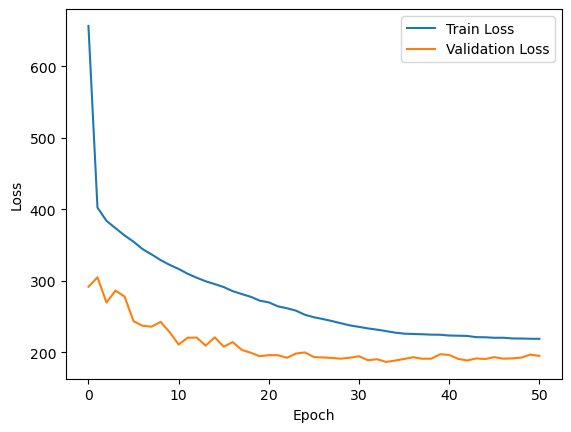

In [29]:
plt.plot(train_losses, label='Train Loss');
plt.plot(val_losses, label='Validation Loss');
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();
plt.show();

> Testing random graphs

In [24]:
G = val_dataset[0]
batch = torch.zeros(G.x.shape[0], dtype=torch.long)

target = torch.cat((G.rec_w.unsqueeze(1), G.rec_h.unsqueeze(1)), dim=1)
predicted = model(G)

print(f"target: {target}\n\npredicted: {predicted}")

target: tensor([[ 23.,  38.],
        [111.,  64.],
        [ 24.,  37.],
        [ 35.,  49.],
        [ 45.,  49.],
        [ 45.,  39.]], device='cuda:0')

predicted: tensor([[ 30.1437,  26.7332],
        [116.7874,  79.0473],
        [ 39.3770,  36.0152],
        [ 50.7080,  42.8041],
        [ 51.1596,  43.2773],
        [ 50.6138,  44.5574]], device='cuda:0', grad_fn=<AddmmBackward0>)
